# Structure learning with PyMC3

This notebook shows how one can use `PyMC3` to learn the structure of a Bayesian network $P(X_1, \dots, X_p)$.
A question on [PyMC Discourse](https://discourse.pymc.io/t/structure-learning-of-bayesian-networks/3845/11) made me wonder with how much extra effort this could be achieved. 

There are of course way better resources than a Jupyter notebook, so I'll not be explaining much theory here. See for instance Daphne Koller's and Nir Friedman's [book](https://mitpress.mit.edu/books/probabilistic-graphical-models). We will use the *student network* example from the book.

**As usual I do not take warranty for the correctness or completeness of this document.**

The relevant code can be found [here](https://github.com/dirmeier/structure-learning-with-pymc).

The goal of this notebook is to learn the structure $G$ of a Bayesian network 

\begin{align}
P(X_1, \dots, X_p \mid G) & = \prod_{i=1}^p P(X_i \mid \mathbf{pa}_{X_i})
\end{align}

where the parents-child relations are encoded by the dag $G$. Following most of the literature, we will treat $G$ as a random variable, i.e. in a Bayesian context. The optimization problem we try to solve is:

\begin{align}
\hat{G} = \arg \max P(D \mid G) \ P(G),
\end{align}

i.e. we marginalize out all the parameters of the local probability tables.

In [1]:
import numpy

import networkx
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm

In order to do structure learning, implementing a couple of small python modules is enough:

In [2]:
from bn.bayesian_network import BayesianNetwork
from bn.dag import DAG
from bn.dag_prior import DAGPrior
from bn.sampler import StructureMCMC
from bn.variable import Variable

We shall assume that the variables $X_i$ we use are categorical, such that local conditional distributions $P(X_i \mid \mathbf{pa}_{X_i})$ can be expressed as probability tables. To encode this properly I created a class `Variable` that describes a variable that can have parents. For instance, for the *student network* one variable is difficulty:

In [3]:
difficulty = Variable(
  "difficulty", ["easy", "hard"],
  pd.DataFrame(
    {"difficulty": ["easy", "hard"],
     "probability": [0.6, 0.4]}))
print(difficulty.lpd)

  difficulty  probability
0       easy          0.6
1       hard          0.4


Doing this for all other variables, too, gives us the entire student network. I am using `has_studied` instead of `intelligence` though, cause it is a more sensitive way to classify people.

In [4]:
has_studied = Variable(
  "has_studied", ["no", "yes"],
  pd.DataFrame(
    {"has_studied": ["no", "yes"],
     "probability": [0.7, 0.3]}))
print(has_studied.lpd)

  has_studied  probability
0          no          0.7
1         yes          0.3


In [5]:
sat = Variable(
  "sat", ["low", "high"],
  pd.DataFrame(
    {"has_studied": numpy.repeat(["no", "yes"], 2),
     "sat": numpy.tile(["low", "high"], 2),
     "probability": [0.95, 0.05, 0.2, 0.8]}))
print(sat.lpd)

  has_studied   sat  probability
0          no   low         0.95
1          no  high         0.05
2         yes   low         0.20
3         yes  high         0.80


In [6]:
letter = Variable(
  "letter", ["weak", "strong"],
  pd.DataFrame(
    {"grade": numpy.repeat(["good", "ok", "bad"], 2),
     "letter": numpy.tile(["weak", "strong"], 3),
     "probability": [0.1, 0.9, 0.4, 0.6, 0.99, 0.01]}))
print(letter.lpd)

  grade  letter  probability
0  good    weak         0.10
1  good  strong         0.90
2    ok    weak         0.40
3    ok  strong         0.60
4   bad    weak         0.99
5   bad  strong         0.01


In [7]:
grade = Variable(
  "grade", ["good", "ok", "bad"],
  pd.DataFrame(
    {"difficulty": numpy.tile(numpy.repeat(["easy", "hard"], 3), 2),
     "has_studied": numpy.repeat(["no", "yes"], 6),
     "grade": numpy.tile(["good", "ok", "bad"], 4),
     "probability": [0.3, 0.4, 0.3, 0.05, 0.25, 0.7, 0.9, 0.08, 0.02, 0.5, 0.3, 0.2]}))
print(grade.lpd)

   difficulty has_studied grade  probability
0        easy          no  good         0.30
1        easy          no    ok         0.40
2        easy          no   bad         0.30
3        hard          no  good         0.05
4        hard          no    ok         0.25
5        hard          no   bad         0.70
6        easy         yes  good         0.90
7        easy         yes    ok         0.08
8        easy         yes   bad         0.02
9        hard         yes  good         0.50
10       hard         yes    ok         0.30
11       hard         yes   bad         0.20


In addition we need some class that encodes the structure itself, i.e., a random variable that we can optimize over. It is easiest to ecnode the structure as an adjacency matrix $G$:

In [8]:
adj = numpy.array(
  [
      [0, 1, 0, 0, 0],
      [0, 0, 0, 1, 0],
      [0, 1, 0, 0, 1],
      [0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0]
  ], dtype=numpy.int8)

The variables $X_i$ and the adj $G$ define the Bayesian network. A Bayesian network is a random variable, so we put it into a model block. For now, we keep the DAG fixed.

In [9]:
with pm.Model() as m:
    dag = DAG(variables=[difficulty, grade, has_studied, letter, sat], adj=adj)
    bn = BayesianNetwork('bn', dag=dag)

Let's visualize the network:

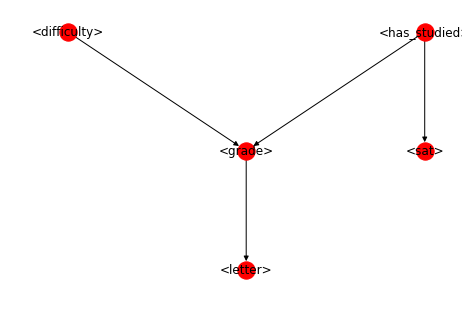

In [10]:
G = bn.distribution.as_graph()
layout = networkx.shell_layout(G)
layout[difficulty] = numpy.array([2, 4])
layout[has_studied] = numpy.array([4, 4])
layout[grade] = numpy.array([3, 3])
layout[letter] = numpy.array([3, 2])
layout[sat] = numpy.array([4, 3])

networkx.draw(G, pos=layout, with_labels=True)

Since we implemented everything against PyMC we can use the network to generate data:

In [17]:
with m:    
    data = pm.sample_prior_predictive(1000, random_seed=23)['bn']

Note that when we create date, it is encoded as integers to comply with PyMC.

In [12]:
data.head()

,difficulty,grade,has_studied,letter,sat
0,1,0,1,0,1
1,1,1,1,0,0
2,1,0,0,0,1
3,0,2,1,0,1
4,0,0,1,1,0


We can also sample from the posterior. However, for structure learning we are usually interested in point estimates and not the full posterior. Since the DAG space is too big, doing proper Bayesian inference is futile anyway. 

If we want to sample from the posterior, we need to treat the DAG as a random variable, so the code block changes a little. Doing posterior inference required implementation of a proper sampler (structure MCMC), which is able to add/remove/reverse edges of the DAG.

In [18]:
with pm.Model():
    dag = DAGPrior(
        'dag', variables=[difficulty, grade, has_studied, letter, sat])
    bn = BayesianNetwork('bn', dag=dag, observed=data)
    step = StructureMCMC([dag], data=data)
    trace = pm.sample(draws=5, tune=1, chains=1, cores=1,
                      step=step, random_seed=23)

Only 5 samples in chain.
Sequential sampling (1 chains in 1 job)
StructureMCMC: [dag]
100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


In [19]:
trace['dag']

array([[[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]]])

If we want to find the optimal DAG, we need to optimize the objective. Starting from a random sample from above:

In [20]:
best = trace['dag'][0].copy()
best_score = -numpy.Inf
numpy.random.seed(2)

for i in range(100):
    adj, score = step.random(adj)
    if best_score < score:
        best = adj.copy()
        best_score = score

Let's see if the learnt structure is fine. Remember that we can only identify the equivalence class of a DAG, so don't be alarmed if arrows other than v-structures are reversed.

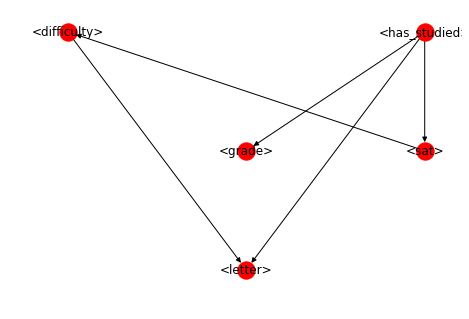

In [21]:
G = bn.distribution.as_graph(best)
networkx.draw(G, pos=layout, with_labels=True)